# Aprendizaje por refuerzo y policy gradient

In [4]:
import numpy as np
import matplotlib.pyplot as plt

En este notebook abordaremos conceptos fundamentales del aprendizaje por refuerzo (Reinforcement Learning), incluyendo:

- Trial & error.
- El dilema entre exploración vs explotación.
- Elementos básicos de Aprendizaje por Refuerzo: agente (*actor*), estados, acciones, política $ \pi $ y parámetros $ \theta $.
- Introducción al método de **gradiente de política (policy gradient)**.

## Creación del ambiente: laberinto

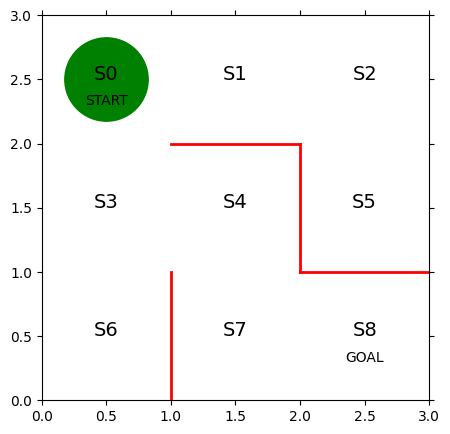

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# Definimos 9 estados (s0 - s8), correspondientes a las 9 celdas del laberinto
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

## Definición de $\theta_0$

Empecemos por parametrizar una política inicial. 

Si encontramos un 1, significa que la acción está disponible en ese estado.

In [ ]:
# ↑、→、↓、←
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7
                    ])

# Como s8 es la meta, ahí no hay decisión

## Obtención de $\pi_\theta$ a partir de $\theta$

Obtengamos ahora nuestra política como una tabla de porcentajes.

Dado que $\pi(a|s)$ es una distribución de probabilidad, construimos una tabla donde cada renglón (correspondiente a un estado) suma a 1.

In [ ]:
def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])

    pi = np.nan_to_num(pi)  # Reemplaza NaNs con 0s

    return pi


In [8]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

Alternativamente, podemos usar la función softmax.

In [25]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m, n] = theta.shape 
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta) 

    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :]) # Softmax

    pi = np.nan_to_num(pi)

    return pi

In [26]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.   , 0.5  , 0.5  , 0.   ],
       [0.   , 0.5  , 0.   , 0.5  ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [0.333, 0.333, 0.333, 0.   ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   ]])

## Muestreo de la política

Para una cierta política $\pi$, podemos ver cómo se comportaría el agente si la sigue.

In [47]:
def get_next_s(pi, s):
    direction = ["up", "right", "down", "left"]

    # La dirección a tomar se elige de acuerdo a la distribución pi[s,:]
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        s_next = s - 3
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + 3
    elif next_direction == "left":
        s_next = s - 1

    return s_next


## Caminando aleatoriamente

Veamos cómo le va al agente con esta política $\pi_0$, obtenida de $\theta_0$.

In [28]:
def goal_maze(pi):
    s = 0 
    state_history = [0]

    while True:  # Loop until goal
        next_s = get_next_s(pi, s)
        state_history.append(next_s)

        if next_s == 8:
            break
        else:
            s = next_s

    return state_history

In [29]:
state_history = goal_maze(pi_0)

In [38]:
print(state_history)
print("Pasos tomados hasta llegar a la meta: " + str(len(state_history) - 1))


[0, 1, 2, 5, 2, 5, 2, 5, 2, 5, 2, 1, 2, 1, 2, 5, 2, 1, 2, 5, 2, 1, 2, 5, 2, 5, 2, 1, 0, 3, 4, 3, 6, 3, 4, 3, 0, 3, 4, 7, 8]
Pasos tomados hasta llegar a la meta: 40


In [34]:
from matplotlib import animation
from IPython.display import HTML


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    state = state_history[i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data([x], [y])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    state_history), interval=200, repeat=False)

HTML(anim.to_jshtml())


## Mejorando nuestra política vía policy gradient

Introduciremos ahora las actualizaciones tipo policy gradient, con el objetivo de mejorar el comportamiento de nuestro agente.

In [35]:
# Extendemos esta fución para recuperar la acción elegida
def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    
    # La dirección a tomar se elige de acuerdo a la distribución pi[s,:]
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3
    elif next_direction == "right":
        action = 1
        s_next = s + 1
    elif next_direction == "down":
        action = 2
        s_next = s + 3
    elif next_direction == "left":
        action = 3
        s_next = s - 1

    return [action, s_next]

In [36]:
# Extendemos esta función de igual manera
def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]] # [(s0, a0), (s1, a1), ...]

    while True: # Loop until goal
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action

        s_a_history.append([next_s, np.nan])
        
        if next_s == 8:
            break
        else:
            s = next_s

    return s_a_history

In [41]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("Pasos tomados hasta llegar a la meta: " + str(len(s_a_history) - 1))

[[0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 0], [0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2],

## Algoritmo REINFORCE

El algoritmo **REINFORCE** es una implementación concreta del enfoque de policy gradient.



Dado un conjunto de parámetros $\theta$ que definen una política estocástica $\pi_\theta(a|s)$, el objetivo es **maximizar la recompensa esperada**:

$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ R(\tau) \right]
$$

donde $\tau = (s_0, a_0, r_1, \dots, s_T)$ es una trayectoria generada por seguir la política $\pi_\theta$.

La derivada del objetivo se estima como:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t \right]
$$

donde $G_t$ es el retorno total desde el tiempo $t$:
$$
G_t = \sum_{k=t+1}^{T} r_k
$$

El algoritmo REINFORCE estima este gradiente usando **Monte Carlo**, es decir, simulando trayectorias completas y actualizando:

$$
\theta \leftarrow \theta + \eta \cdot \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t
$$

Es un método libre del modelo: funciona aún cuando no se conoce la dinámica del ambiente.

In [ ]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # learning rate
    T = len(s_a_history) - 1  # Total steps to goal

    [m, n] = theta.shape
    delta_theta = theta.copy()

    # Calculamos delta_theta elemento por elemento
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):

                # This is a list comprehension that extracts state i from the history.
                SA_i = [SA for SA in s_a_history if SA[0] == i]

                # Extract those who performed action j in state i
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]

                N_i = len(SA_i)  # Total number of actions taken in state i
                N_ij = len(SA_ij)  # Number of times action j was taken in state i
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

El código que usamos implementa una **versión tabular** del método REINFORCE. En lugar de derivar $\log \pi_\theta(a|s)$, se cuenta cuántas veces se tomó una acción $a$ en un estado $s$:

`delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T `

Esto se interpreta como una estimación del gradiente: si la acción $j$ se tomó más veces de lo que la política actual predice en el estado $i$, **aumentamos la probabilidad** de esa acción.

Finalmente, se actualiza:

$$
\theta \leftarrow \theta + \eta \cdot \Delta\theta
$$

donde $\Delta\theta$ está construida a partir de las **frecuencias observadas en la trayectoria** y de la política actual $\pi$.

Esta forma de actualizar privilegia las acciones que ocurrieron con mayor frecuencia de lo esperado y penaliza las menos frecuentes, empujando la política hacia aquellas que conducen al objetivo.




In [ ]:
# Obtengamos el update de la política
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.500625   0.499375   0.        ]
 [0.         0.499375   0.         0.500625  ]
 [0.         0.         0.50125    0.49875   ]
 [0.33305544 0.33388912 0.33305544 0.        ]
 [0.         0.         0.499375   0.500625  ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.499375   0.500625   0.         0.        ]]


In [ ]:
# Resolvamos el laberinto utilizando REINFORCE

stop_epsilon = 10**-4  # Stop learning when the policy changes less than .0001

theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  
    s_a_history = goal_maze_ret_s_a(pi)  # Find the history of exploring the maze with policy π
    new_theta = update_theta(theta, pi, s_a_history) # Update a theta
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # Obtenciónde pi_theta
    
    print("Pasos tomados hasta llegar a la meta: " + str(len(s_a_history) - 1))
    print("\tCambio en la política: ", np.sum(np.abs(new_pi - pi)))  # Output the change in policy

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

Pasos tomados hasta llegar a la meta: 26
	Cambio en la política:  0.015169755284695885
Pasos tomados hasta llegar a la meta: 22
	Cambio en la política:  0.014154453409963241
Pasos tomados hasta llegar a la meta: 20
	Cambio en la política:  0.017074392536667815
Pasos tomados hasta llegar a la meta: 14
	Cambio en la política:  0.030888360926029146
Pasos tomados hasta llegar a la meta: 24
	Cambio en la política:  0.015226535588596768
Pasos tomados hasta llegar a la meta: 46
	Cambio en la política:  0.012659790254959224
Pasos tomados hasta llegar a la meta: 26
	Cambio en la política:  0.009792457011637556
Pasos tomados hasta llegar a la meta: 30
	Cambio en la política:  0.009999468838099712
Pasos tomados hasta llegar a la meta: 106
	Cambio en la política:  0.00885907352103188
Pasos tomados hasta llegar a la meta: 30
	Cambio en la política:  0.015743495969672838
Pasos tomados hasta llegar a la meta: 180
	Cambio en la política:  0.00533889490089251
Pasos tomados hasta llegar a la meta: 62
	C

In [ ]:
# Política final
np.set_printoptions(precision=3, suppress=True)
print(pi)

[[0.    0.012 0.988 0.   ]
 [0.    0.275 0.    0.725]
 [0.    0.    0.432 0.568]
 [0.009 0.977 0.014 0.   ]
 [0.    0.    0.989 0.011]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.019 0.981 0.    0.   ]]


## Visualización

Veamos cómo le va al agente después de entrenarse.

In [46]:
from matplotlib import animation
from IPython.display import HTML


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    state = s_a_history[i][0]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data([x], [y])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())